Source Separation with Sparsity
===============================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour explore local Fourier analysis of sounds, and its
application to source separation from stereo measurements.

In [1]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"

library(Matrix)
library(tuneR)
library(colorRamps)
library(audio)

# Importing the libraries
for (f in list.files(path="nt_toolbox/toolbox_general/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_general/", f, sep=""))
}
for (f in list.files(path="nt_toolbox/toolbox_signal/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_signal/", f, sep=""))
}


Attaching package: ‘audio’

The following object is masked from ‘package:tuneR’:

    play


Attaching package: ‘pracma’

The following objects are masked _by_ ‘.GlobalEnv’:

    circshift, fftshift, grad, ifftshift

The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu



Sound Mixing
------------
We load 3 sounds and simulate a stero recording by performing a linear
blending of the sounds.

Sound loading.

In [2]:
n = 1024*16
s = 3 #number of sounds
p = 2 #number of micros

x = Matrix(0,nrow=n, ncol=3)
x[,1] = as.vector(load_sound("nt_toolbox/data/bird.wav", n))
x[,2] = as.vector(load_sound("nt_toolbox/data/female.wav", n))
x[,3] = as.vector(load_sound("nt_toolbox/data/male.wav", n))

Normalize the energy of the signals.

In [3]:
x = x/matrix(rep(c(sd(x[,1]),sd(x[,2]),sd(x[,3])),each=n),nrow=n)

We mix the sound using a $2\mathrm{x}3$ transformation matrix.
Here the direction are well-spaced, but you can try with more complicated
mixing matrices.

Compute the mixing matrix

In [4]:
theta = seq(from=0, to =pi, by=pi/s)[-(s+1)]
theta[1] = 0.2
M = rbind(cos(theta),sin(theta))

Compute the mixed sources.

In [5]:
y = x %*% t(M)

Display of the sounds and their mix.

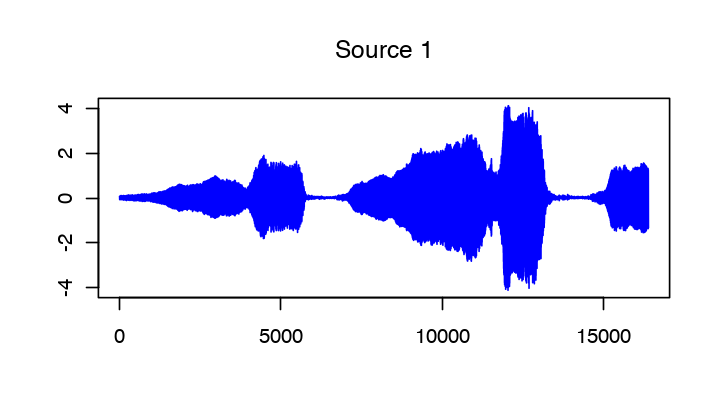

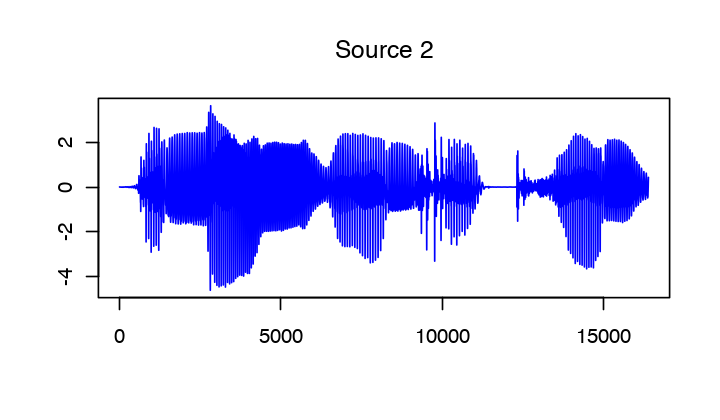

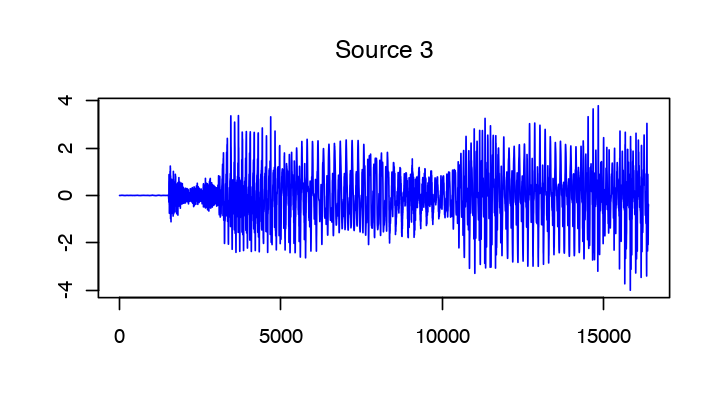

In [6]:
options(repr.plot.width=6, repr.plot.height=3.5)
for (i in (1:s)){
    plot(x[, i], main=paste("Source", i), type="l", ylab="", xlab="", col="blue")
    }

Display of the micro output.

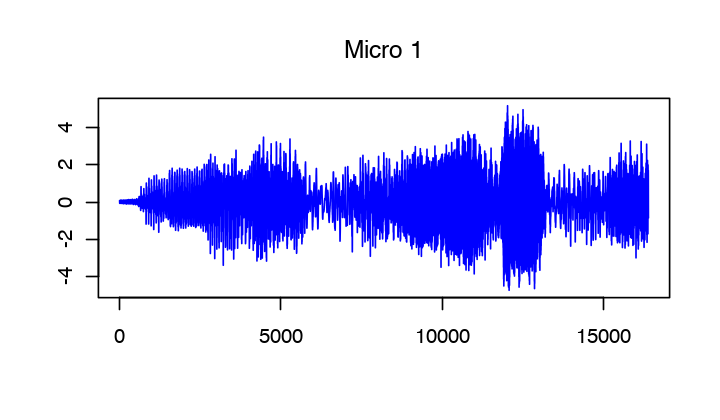

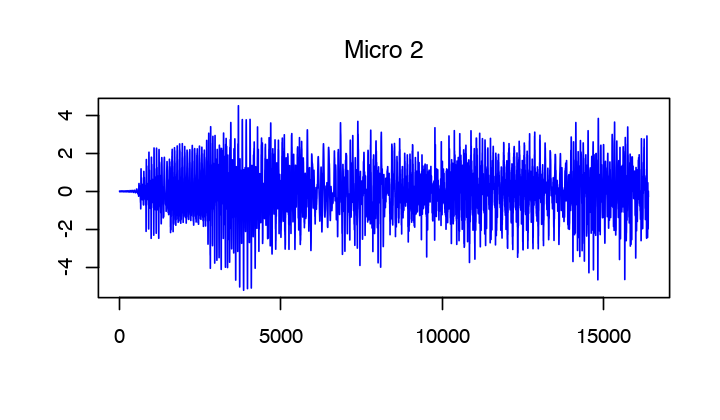

In [7]:
options(repr.plot.width=6, repr.plot.height=3.5)
for (i in (1:p)){
    plot(y[, i], main=paste("Micro", i), type="l", ylab="", xlab="", col="blue")
    }

Local Fourier analysis of sound.
--------------------------------
In order to perform the separation, one performs a local Fourier analysis
of the sound. The hope is that the sources will be well-separated over
the Fourier domain because the sources are sparse after a STFT.




First set up parameters for the STFT.

In [8]:
w = 128   #size of the window
q = floor(w/4)  #overlap of the window

Compute the STFT of the sources.

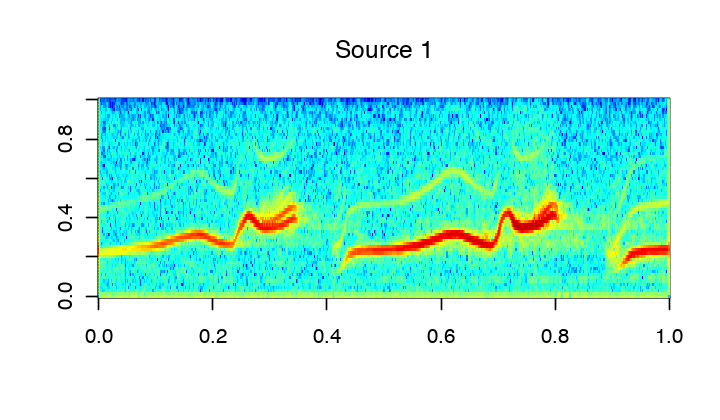

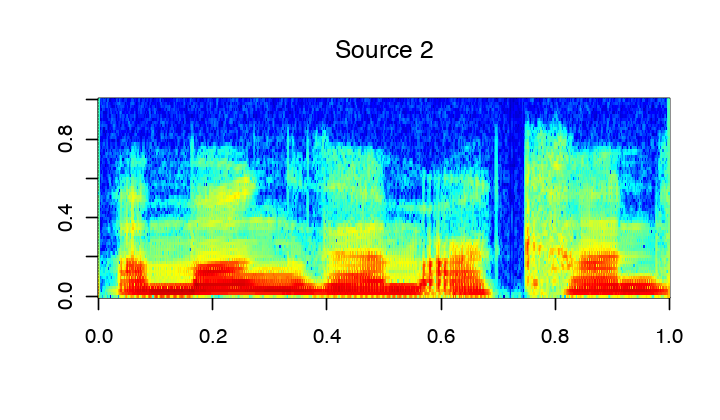

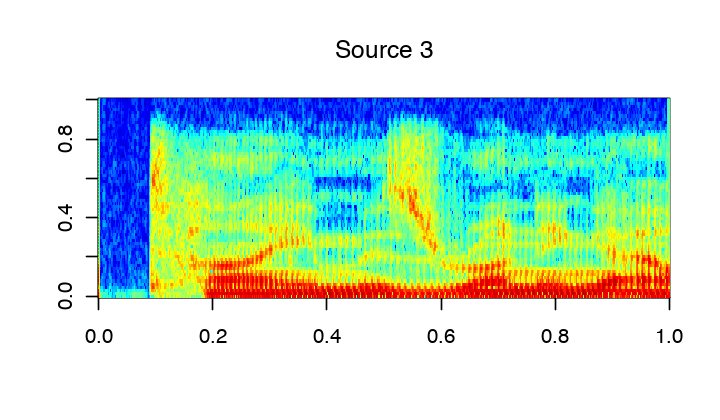

In [9]:
X = replicate(s, Matrix(0,nrow=w,ncol=4*w+1), simplify=FALSE)
Y = replicate(p, Matrix(0,nrow=w,ncol=4*w+1), simplify=FALSE)

for (i in (1:s))
{
    X[[i]] = perform_stft(x[,i], w,q,n)
    plot_spectogram(X[[i]], paste("Source", i))
}

__Exercise 1__

Compute the STFT of the micros, and store them into a matrix |Y|.

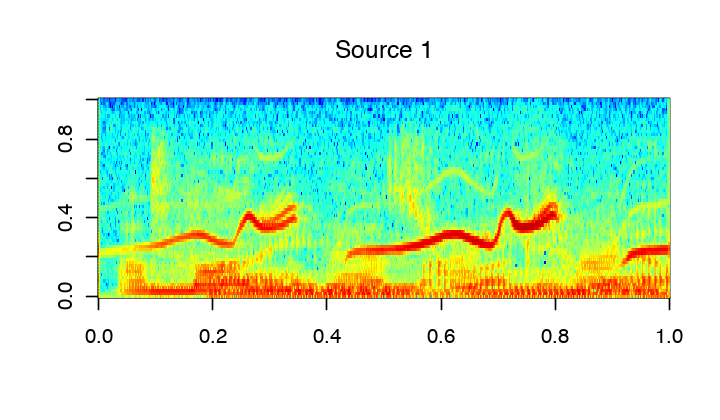

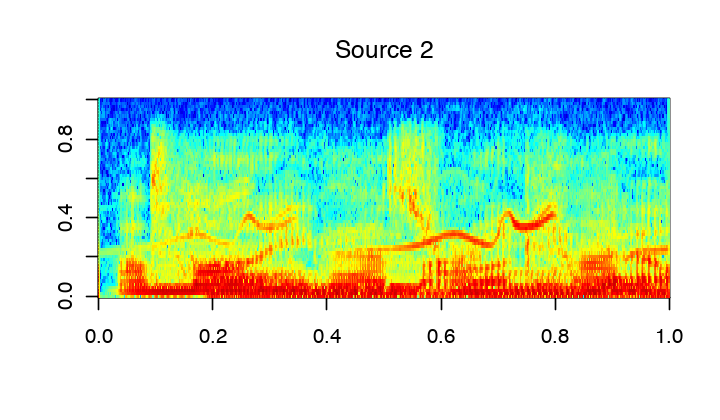

In [10]:
source("nt_solutions/audio_separation/exo1.R")

In [11]:
## Insert your code here.

Estimation of Mixing Direction by Clustering
--------------------------------------------
Since the sources are quite sparse over the Fourier plane, the directions
are well estimated by looking as the direction emerging from a point
clouds of the transformed coefficients.


First we compute the position of the point cloud.

In [12]:
mf = dim(Y[[1]])[1]
mt = dim(Y[[1]])[2]
P = matrix(0, nrow=mt*mf, ncol=p)
c = c()
d = c()
for (j in (1:mf))
{
    c = c(c,Y[[1]][j,])
    d = c(d,Y[[2]][j,])
}
P[,1] = c
P[,2] = d
P = rbind(Re(P), Im(P))

Then we keep only the 5% points with largest energy.


Display some points in the original (spacial) domain.

Number of displayed points.

In [13]:
npts = 6000

Display the original points.

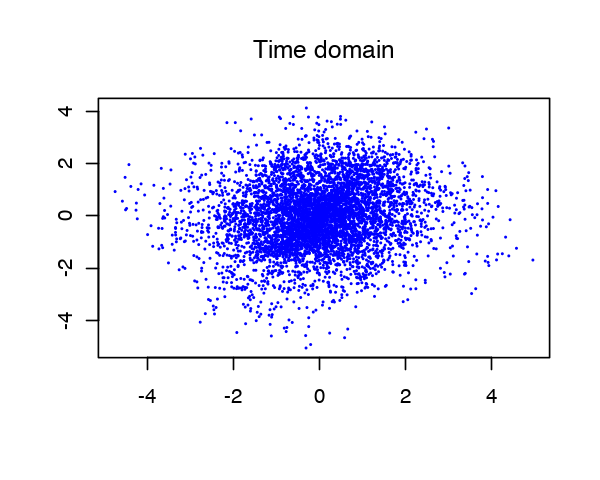

In [14]:
options(repr.plot.width=5, repr.plot.height=4)

sel = sample(n)

sel = sel[1:npts]

plot(y[sel,1], y[sel,2], type="p", pch=19, col = "blue", cex=0.05, main="Time domain", xlab="", ylab="")

__Exercise 2__

Display some points of $P$ in the transformed (time/frequency) domain.

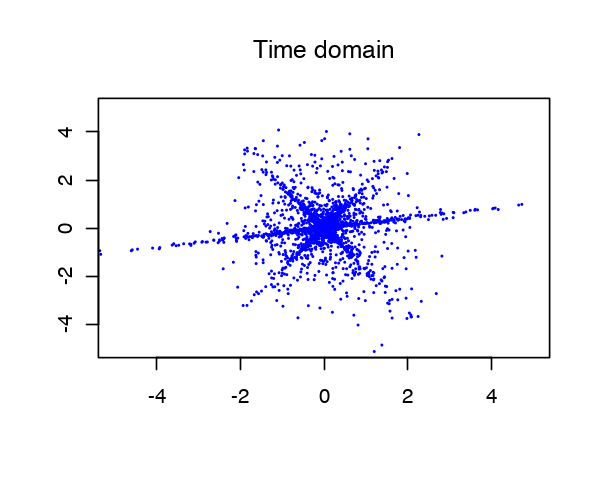

In [15]:
source("nt_solutions/audio_separation/exo2.R")

In [16]:
## Insert your code here.

We compute the angle associated to each point over the transformed
domain. The histogram shows the main direction of mixing.

In [17]:
nrow = dim(P)[1]
Theta = c()
for (i in (1:nrow))
{
    Theta[i] = atan2(P[i,2], P[i,1])%%pi
}

Display histogram.

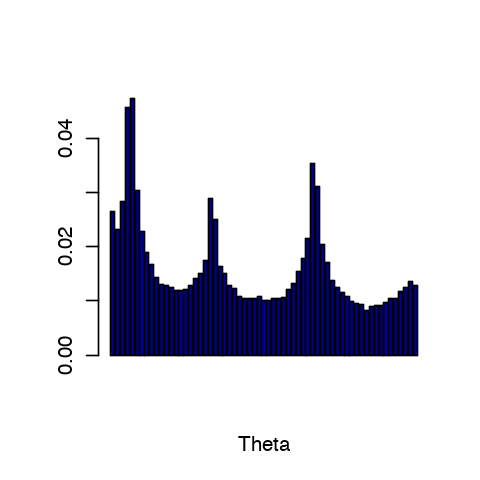

In [18]:
options(repr.plot.width=4, repr.plot.height=4)

nbins = 100
t = seq(from=pi/200, pi, (pi-pi/200)/(nbins-1))
hist = hist(Theta, xlim=c(min(Theta),max(Theta)), main="", breaks=nbins, plot=FALSE)
h = hist$counts/sum(hist$counts)
barplot(h, xlab="Theta", col ="DarkBlue" , tick=TRUE)

__Exercise 3__

The histogram computed from the whole set of points are not peacked
enough. To stabilize the detection of mixing direction, compute an
histogram from a reduced set of point that have the largest amplitude.
Compute the energy of each point. Extract only a small sub-set.

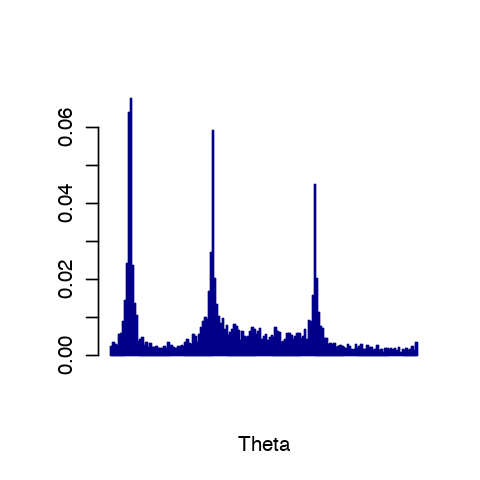

In [19]:
source("nt_solutions/audio_separation/exo3.R")

In [20]:
## Insert your code here.

__Exercise 4__

Detect the direction $M_1$ approximating the true direction $M$ by
looking at the local maxima of the histogram. First detect the set of
local maxima, and then keep only the three largest. Sort in descending order.

In [21]:
source("nt_solutions/audio_separation/exo4.R")

          [,1]      [,2]       [,3]
[1,] 0.9800666 0.5000000 -0.5000000
[2,] 0.1986693 0.8660254  0.8660254
          [,1]      [,2]       [,3]
[1,] 0.9851093 0.6730125 -0.0784591
[2,] 0.1719291 0.7396311  0.9969173


In [22]:
## Insert your code here.

Separation of the Sources using Clustering
------------------------------------------
Once the mixing direction are known, one can project the sources on the
direction.


We compute the projection of the coefficients Y on each estimated
direction.

In [23]:
A = matrix(0, nrow=mt*mf, ncol=p)
c = c()
d = c()
for (j in (1:mf))
{
    c = c(c,Y[[1]][j,])
    d = c(d,Y[[2]][j,])
}
A[,1] = c
A[,2] = d

Compute the projection of the coefficients on the directions.

In [24]:
C = abs(t(M) %*% t(A))

At each point $x$, the index $I(x)$ is the direction which creates the
largest projection.

$I$ is the index of the closest source.

In [25]:
vec = c(1:dim(C)[2])
tmp = apply(C[,vec],2,max)
I = max.col(t(C))
I = t(matrix(I, nrow=mt, ncol=mf))

An additional denoising is achieved by removing small coefficients.

In [26]:
T = .05
D = sqrt(abs(Y[[1]])**2+abs(Y[[2]])**2)
I = I*(D > T)

We can display the segmentation of the time frequency plane.

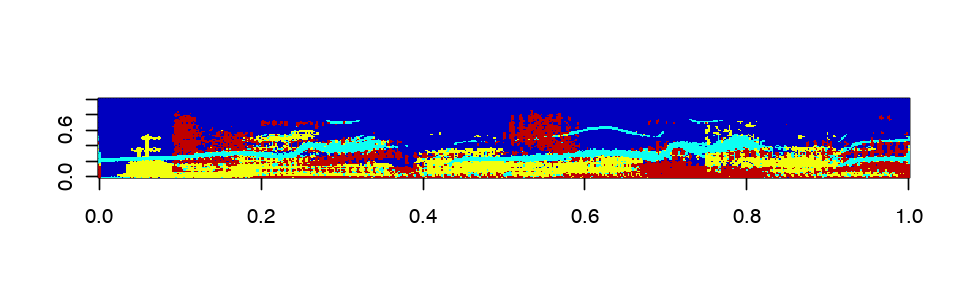

In [27]:
options(repr.plot.width=8, repr.plot.height=2.5)
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"

image(t(I[1:floor(mf/2),]),col=matlab.like2(50),interpolation_type="nearest")

The recovered coefficients are obtained by projection.

In [28]:
Proj = t(M) %*% t(A)
Xr = replicate(s, matrix(0,nrow=w,ncol=4*w+1), simplify=FALSE)
for (i in (1:s))
{
    Xr[[i]] = t(matrix(Proj[i,], nrow=mt, ncol=mf))*((I+1)==i)
}

The estimated signals are obtained by inverting the STFT.

In [29]:
xr = Matrix(0, nrow=n, ncol=s)
for (i in (1:s))
{
    xr[,i] = perform_stft(Re(Xr[[i]]), w,q,n)
}


One can display the recovered signals.

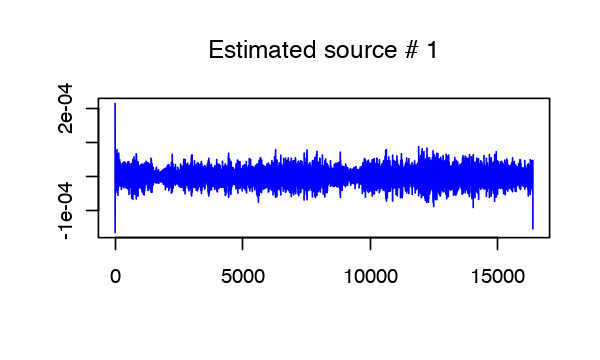

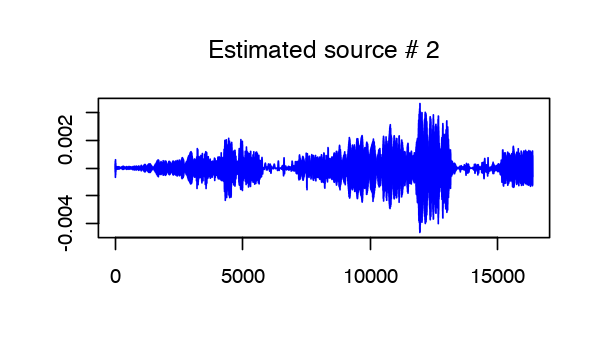

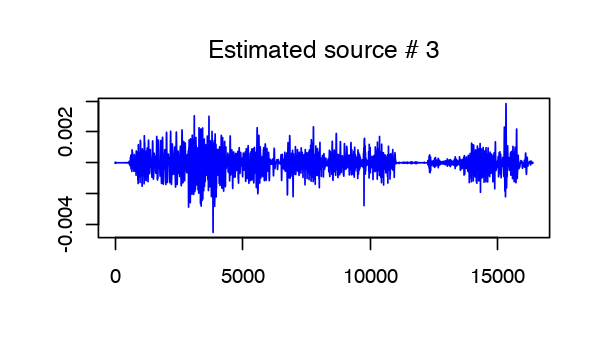

In [30]:
options(repr.plot.width=5, repr.plot.height=3)
for (i in (1:s))
{
    plot(xr[,i], main=paste("Estimated source #", i), type="l", ylab="", xlab="", col="blue")
}

One can listen to the recovered sources.

In [54]:
i = 3
play(x[,i], rate=15000)

In [52]:
play(xr[,i] * 1e4, rate=15000)

In [ ]:
<script>
  $(document).ready(function(){
      $('div.prompt').hide();
  });
</script>

<script>
  $(document).ready(function(){
      $('div.prompt').hide();
  });
</script>